# DESC fringes on ExitScreen

In [18]:
%matplotlib inline

import h5py;
from matplotlib import pyplot as plt
import numpy as np
import skimage.measure as sm

### Plot settings 

In [19]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize' : (10,10)})

## DAQ run with constant delay at time zero 

In [3]:
run_number = 28495

data_dir = '/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/'
hdf_filename = 'FLASH1_USER1-run'+str(run_number)+'.h5'
image_path = '/asap3/flash/gpfs/bl1/2017/data/11003895/processed/notebooks/fig/'

print(data_dir+hdf_filename)

/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/FLASH1_USER1-run28495.h5


### Read Images from h5 file 

In [4]:
hdf_file = h5py.File(data_dir+hdf_filename,'r')
img = hdf_file['/uncategorised/FLASH1_USER1/FLASH.FEL/FBL1.CAM/EXIT_SCREEN/dset'][()]
print(type(img),'|',img.shape)

<class 'numpy.ndarray'> | (6000, 1280, 960)


###  Plot Single Image  & Crop to ROI

fig/fringe_image_1009


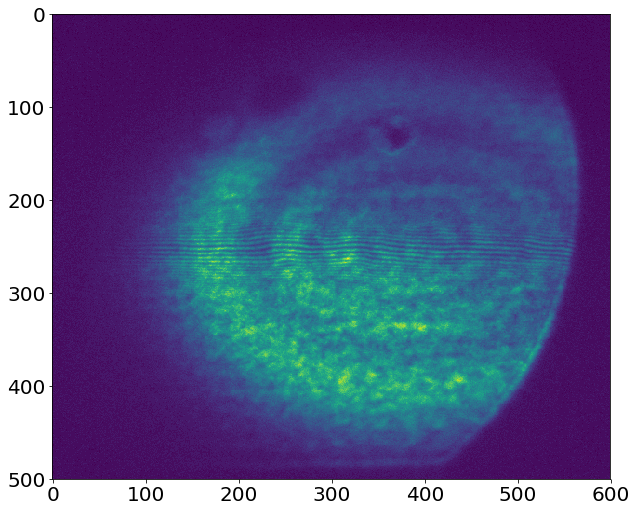

In [5]:
img_nummer = 1009

ROI_x1 = 200
ROI_x2 = 700
ROI_y1 = 100
ROI_y2 = 700

for index in range(img_nummer,img_nummer+1):
    img_name = 'fig/fringe_image_{:04d}'.format(index)
    single_img = img[index][ROI_x1:ROI_x2,ROI_y1:ROI_y2]
    print(img_name)
    plt.clf()
    plt.imshow(single_img)
#     plt.imsave(imgName,singleImg)

## DAQ drop rate
### Integrate cropped Image

In [6]:
integral = np.asarray([np.sum(img[index][ROI_x1:ROI_x2,ROI_y1:ROI_y2]) for index in range(0,img.shape[0])]) 
lit_treshold = 100000
logic_map = (integral > lit_treshold)

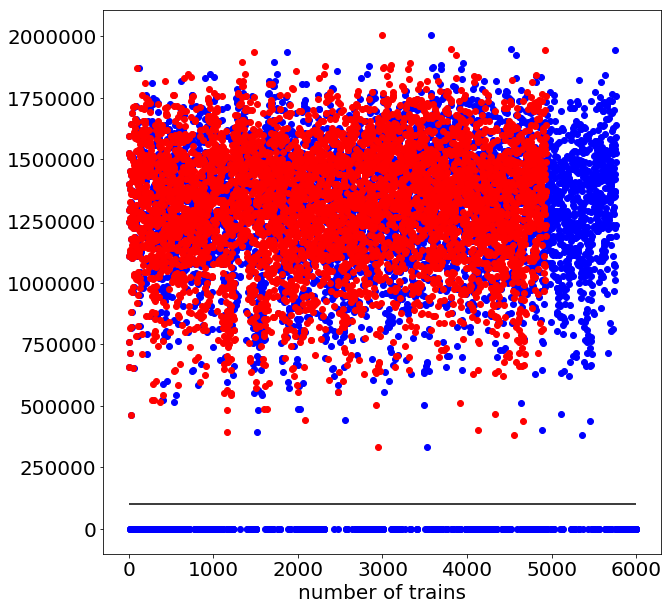

In [7]:
plt.plot(integral,'bo')
plt.plot(integral[logic_map],'ro')
plt.hlines(lit_treshold, 0, len(integral))
plt.xlabel('number of trains');

In [8]:
res = [i for i, val in enumerate(logic_map) if val]
print('Number of blanks in the end:', len(logic_map)-res[-1])
print('Acutal Rate in dataset (without appended blanks): % .3f '%(len(res)/res[-1]))

Number of blanks in the end: 236
Acutal Rate in dataset (without appended blanks):  0.857 


## Cut blanks from dataset & Crop all images to ROI

In [9]:
print('Before:',img.shape)
img = img[logic_map][:,ROI_x1:ROI_x2,ROI_y1:ROI_y2]
print('After:',img.shape)

Before: (6000, 1280, 960)
After: (4938, 500, 600)


## Average Image

(500, 600)


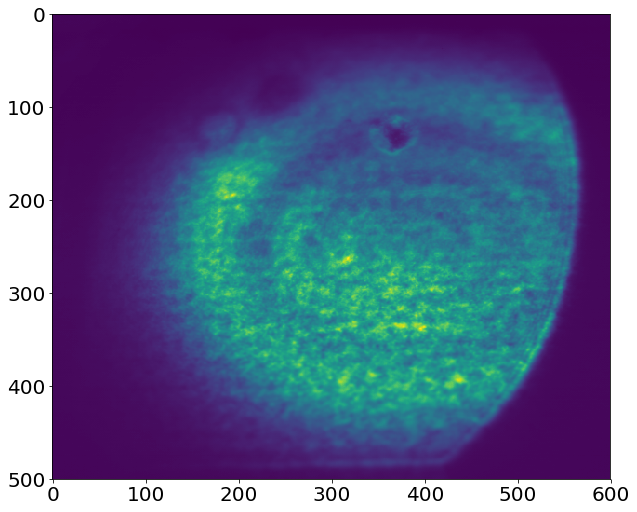

In [10]:
average_img = np.mean(img, axis = 0)
print(average_img.shape)

plt.imshow(average_img);

### Single Image - Average Image

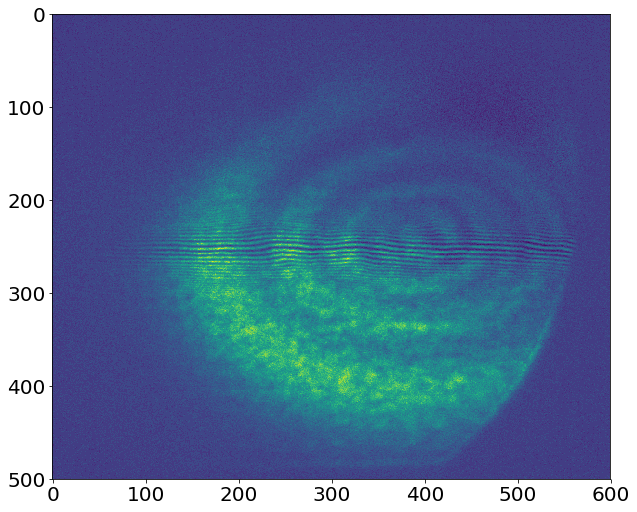

In [11]:
plt.imshow(single_img-average_img);

### Plot with ROI & Min/Max in ROI

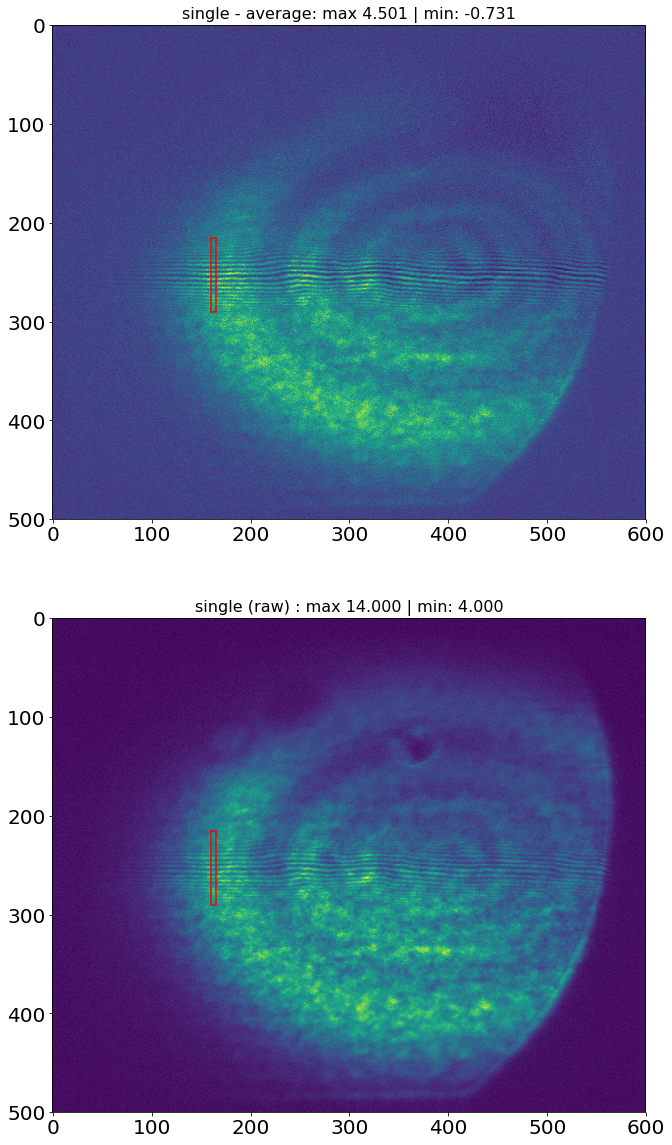

In [12]:
fringe_roi_x1, fringe_roi_y1 = 160, 215 
fringe_roi_x2, fringe_roi_y2 =  165, 290

x_plot_roi = [fringe_roi_x1, fringe_roi_x2, fringe_roi_x2, fringe_roi_x1, fringe_roi_x1]
y_plot_roi = [fringe_roi_y1, fringe_roi_y1, fringe_roi_y2, fringe_roi_y2, fringe_roi_y1]

shown_img = single_img-average_img

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(shown_img)
plt.plot(x_plot_roi,y_plot_roi,'r-')
plt.title('single - average: max %0.3f | min: %0.3f'%(np.max(shown_img[fringe_roi_x1:fringe_roi_x2,fringe_roi_y1:fringe_roi_y2]),np.min(shown_img[fringe_roi_x1:fringe_roi_x2,fringe_roi_y1:fringe_roi_y2])), fontsize=16)
plt.subplot(212)
plt.imshow(single_img)
plt.plot(x_plot_roi,y_plot_roi,'r-')
plt.title('single (raw) : max %0.3f | min: %0.3f'%(np.max(single_img[fringe_roi_x1:fringe_roi_x2,fringe_roi_y1:fringe_roi_y2]),np.min(single_img[fringe_roi_x1:fringe_roi_x2,fringe_roi_y1:fringe_roi_y2])), fontsize=16);



# Fringe Visibility  (by applying a Low Pass Filter) on Raw Image
## to do: Low Pass Filter

$$FV = \frac{I_{max} - I_{min}}{I_{max}+I_{min}} $$
with $$I = \frac{I_{p}}{I_{f}} $$
where $$I_{p}$$ is the intensity profile and $$I_{f}$$  is a fitted low pass filter if necessary

## Low Pass Filter necessary ?

### Single Image with multiple pixel width

visibilities [0.36363636 0.34328358 0.31818182 0.29355609 0.29723225]


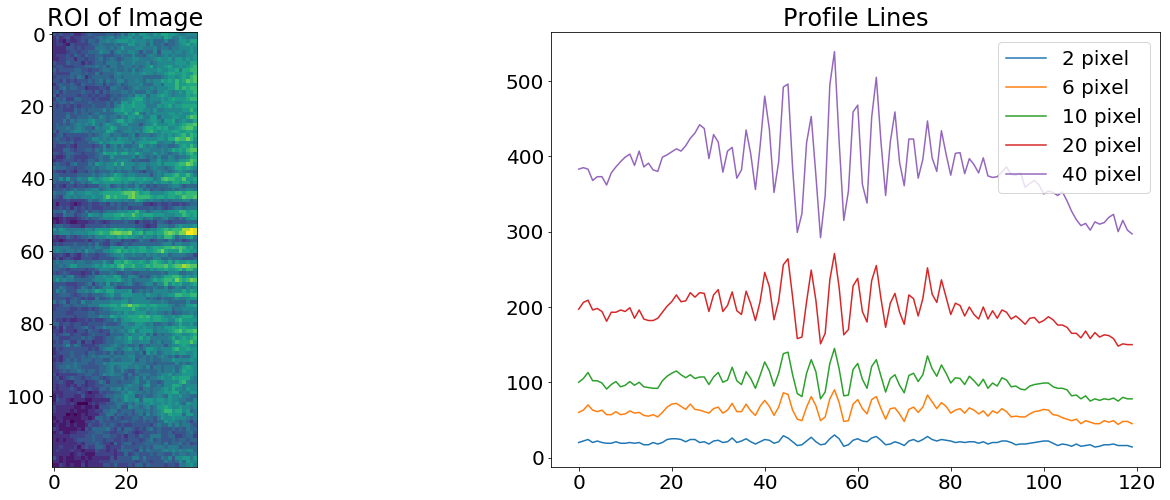

In [13]:
img_nummer = 1009
fringe_roi_image = img[img_nummer][200:320, 140:180] 

profile_width = [2,6,10,20,40]

def extract_profile_line(integrate_image,profile_width):
    start_sum = int(integrate_image.shape[1]/2)-int(profile_width/2)
    end_sum = int(integrate_image.shape[1]/2)+int(profile_width/2)
    return np.sum(integrate_image[:,start_sum:end_sum], axis=1)

def calc_visibility(profile_line):
    maxs = np.max(profile_line)
    mins = np.min(profile_line)
    return (maxs-mins)/(maxs+mins)
    
profile_lines = np.asarray([extract_profile_line(fringe_roi_image, width) for width in profile_width])
visibilities = np.asarray([calc_visibility(profile_lines[index]) for index in range(0,profile_lines.shape[0])])

plt.figure(figsize=(24,8))
plt.subplot(121)
plt.imshow(fringe_roi_image)
plt.title('ROI of Image')

plt.subplot(122)
[plt.plot(profile_lines[index],label ='%i pixel'%profile_width[index]) for index in range(0,profile_lines.shape[0])]
plt.legend()
plt.title('Profile Lines');

print('visibilities',visibilities)

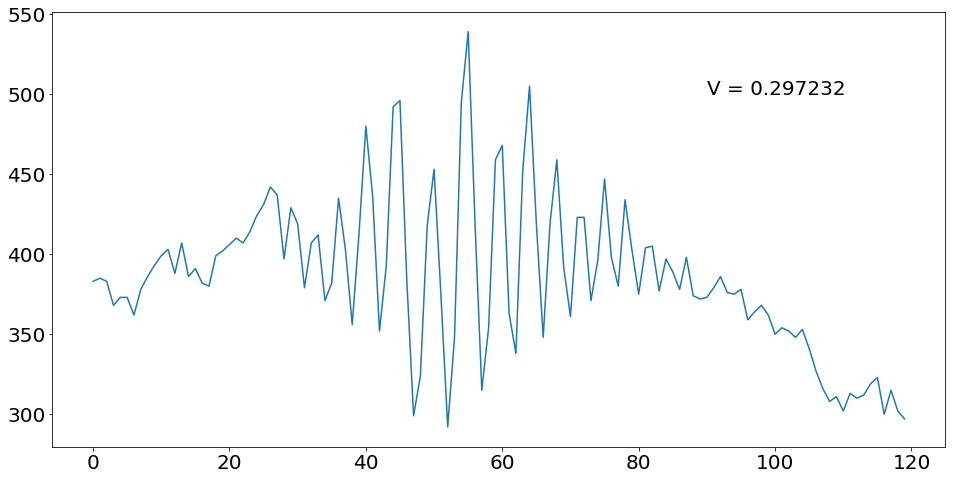

In [14]:
plt.figure(figsize=(16,8))
plt.plot(profile_lines[-1])
plt.text(90,500,'V = %f'%visibilities[-1]);